In [2]:
#抽象类定义
import numpy as np
from abc import abstractmethod

#张量类，基于numpy.array实现
#grad用于记录梯度，bp_cache为一个由二元组构成的列表，记录反向传播的目的张量和计算函数
class Tensor:
    def __init__(self,value):
        self.value = value
        self.grad = np.zeros(value.shape)
        self.bp_cache = []
        
    def backward(self):
        for kwargs,back_func in self.bp_cache:
            back_func(self,**kwargs)
            for name,t in kwargs.items():
                t.backward()
    
    def zero_grad(self):
        self.grad = np.zeros(self.grad.shape)
        for kwargs,back_func in self.bp_cache:
            for name,t in kwargs.items():
                t.zero_grad()

    def __str__(self):
        return 'Value:' + str(self.value) + '\nGradient:' + str(self.grad)

#模型类，forward用于计算正向传播过程，通过调用算子计算函数实现，由算子计算函数在张量中注册反向传播信息
#args方法返回模型的参数供优化器使用，默认情况下会把Module成员中的Tensor视为参数，并对于子模块进行递归参数查找
class Module:
    @abstractmethod
    def forward(self,x):
        return None
    
    def args(self):
        res = []
        for name in vars(self).keys():
            if isinstance(getattr(self,name),Tensor):
                res.append(getattr(self,name))
            elif isinstance(getattr(self,name),Module):
                res += getattr(self,name).args()
        return res
        
    def __call__(self,x):
        return self.forward(x)

#优化器类，step用于对参数张量进行梯度下降
class Optimizer:
    def __init__(self,args,lr):
        self.args = args
        self.lr = lr
    
    @abstractmethod
    def step():
        pass

In [3]:
#带动量的随机梯度下降
class SGD(Optimizer):
    def __init__(self,args,lr = 1e-3,momentum = 0.5):
        Optimizer.__init__(self,args,lr)
        self.m = momentum
        self.v = [np.zeros(args[i].value.shape) for i in range(len(args))]
        
    def step(self):
        for i in range(len(self.args)):
            self.v[i] = self.m * self.v[i] - self.lr * self.args[i].grad
            self.args[i].value += self.v[i]

In [4]:
#全连接层实现
def linear_backward(y,x,w,b):
    x.grad += np.dot(y.grad,w.value.T)
    w.grad += np.dot(x.value.T,y.grad)
    b.grad += y.grad
    
def linear(x,w,b):
    y = Tensor(np.dot(x.value,w.value) + b.value)
    y.bp_cache.append(({
        'x':x,
        'w':w,
        'b':b
    },linear_backward))
    return y
    
class Linear(Module):
    def __init__(self,in_dim,out_dim):
        self.out_dim = out_dim
        self.w = Tensor(np.random.randn(in_dim,out_dim) * 0.1)
        self.b = Tensor(np.random.randn(1,out_dim) * 0.1)
    
    def forward(self,x):
        return linear(x,self.w,self.b)

In [5]:
#ReLU层实现
def relu_backward(y,x):
    x.grad += y.grad * (y.value > 0).astype(np.float32)

def relu(x):
    y = Tensor((x.value > 0).astype(np.float32) * x.value)
    y.bp_cache.append(({
        'x':x,
    },relu_backward))
    return y

class ReLU(Module):
    def forward(self,x):
        return relu(x)

In [6]:
#Sigmoid层实现
def s(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_backward(y,x):
    x.grad += y.grad * s(x.value) * (1 - s(x.value))

def sigmoid(x):
    y = Tensor(s(x.value))
    y.bp_cache.append(({
        'x':x
    },sigmoid_backward))
    return y

class Sigmoid(Module):
    def forward(self,x):
        return sigmoid(x)

In [7]:
#用于实现连续线性的模型组合
class Sequential(Module):
    def __init__(self,*models):
        self.models = models
    
    def forward(self,x):
        for model in self.models:
            x = model(x)
        return x
    
    def args(self):
        r = []
        for model in self.models:
            r += model.args()
        return r

In [8]:
#子类化方式实现神经网络
class Net(Module):
    def __init__(self):
        self.fc1 = Sequential(
            Linear(2,2),
            Sigmoid()
        )
        self.fc2 = Sequential(
            Linear(2,2),
        )
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [9]:
#交叉熵损失实现，softmax被并入交叉熵的计算过程中
def softmax(x):
    e = np.exp(x.value)
    return e / np.sum(e)

def celoss_backward(y,x,label):
    x.grad = softmax(x)
    x.grad[0][label.value[0]] -= 1

def celoss(x,label):
    s = softmax(x)
    l = -np.log(s[0][label.value[0]])
    y = Tensor(np.array([l]))
    y.bp_cache.append(({
        'x':x,
        'label':label
    },celoss_backward))
    return y

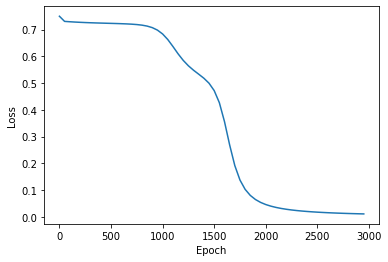

In [11]:
import matplotlib.pyplot as plt

model = Net()
optimizer = SGD(model.args(), lr = 1e-1, momentum = 0)
X = [np.array([[0,0]]),np.array([[0,1]]),np.array([[1,0]]),np.array([[1,1]])]
Y = [np.array([0]),np.array([1]),np.array([1]),np.array([0])]

n_epochs = 3000
milestones = range(0,n_epochs,50)
losses = []
for epoch in range(n_epochs):
    loss = []
    for i in range(len(X)):
        x,y = Tensor(X[i]),Tensor(Y[i])
        pred = model(x)
        l = celoss(pred,y)
        loss.append(l.value[0])
        pred.zero_grad()
        l.backward()
        #print([a.grad for a in optimizer.args],l.value[0])
        #input()
        optimizer.step()
    if epoch in milestones:
        losses.append(np.mean(np.array(loss)))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(milestones,losses) #可视化梯度下降过程 
plt.show()

In [16]:
model(Tensor(X[3])).value

array([[ 2.04850955, -2.13168204]])